In [44]:
# Colab setup
import os
import torch
import lightning

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))


torch.manual_seed(41)

In [45]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sA/COLVAR",
              "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sB/COLVAR" ]
n_states = len(filenames)

dataset, df = create_dataset_from_files(
	filenames,
	filter_args={'regex':'d_' }, # select distances between heavy atoms
	create_labels=True,
	return_dataframe=True,
)

Class 0 dataframe shape:  (5001, 53)
Class 1 dataframe shape:  (5001, 53)

 - Loaded dataframe (10002, 53): ['time', 'phi', 'psi', 'theta', 'xi', 'ene', 'd_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15', 'd_11_16', 'd_11_17', 'd_11_19', 'd_15_16', 'd_15_17', 'd_15_19', 'd_16_17', 'd_16_19', 'd_17_19', 'walker', 'labels']
 - Descriptors (10002, 45): ['d_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15

# Analysis of MLCV

## Load model

In [46]:
from mlcolvar.cvs import AutoEncoderCV

n_components = 1
encoder_layers = [45, 10, 10, n_components]
nn_args = {'activation': 'shifted_softplus'}
options= {'encoder': nn_args, 'decoder': nn_args }

model = AutoEncoderCV (encoder_layers, options=options )
model

AutoEncoderCV(
  (loss_fn): MSELoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=10, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=10, out_features=45, bias=True)
    )
  )
)

In [47]:
checkpoint_file = torch.load('./aecv-v1.pt')
model.load_state_dict(checkpoint_file)
model.eval()

AutoEncoderCV(
  (loss_fn): MSELoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=10, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=10, out_features=45, bias=True)
    )
  )
)

## Visualize

In [48]:
X = dataset[:]['data']
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    df[f'CV{i}'] = s[:,i]

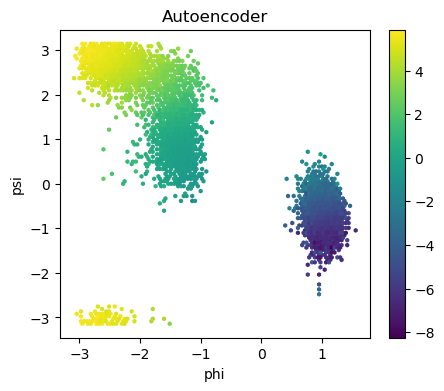

In [40]:
n_components = 1

fig,axs = plt.subplots(1, n_components, figsize = ( 5 * n_components, 4) )
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='viridis',ax=ax)
    ax.set_title(f'Autoencoder')

In [32]:
df

,time,phi,psi,theta,xi,ene,d_2_5,d_2_6,d_2_7,d_2_9,...,d_11_19,d_15_16,d_15_17,d_15_19,d_16_17,d_16_19,d_17_19,walker,labels,CV0
0,0.0,-2.368670,2.644320,-0.202258,0.048056,-41.45820,0.152064,0.233505,0.241173,0.379827,...,0.452694,0.126976,0.130073,0.244001,0.227324,0.281913,0.148169,0,0,4.868144
1,0.2,-2.018990,2.094670,0.183233,-0.178206,-26.63110,0.155185,0.240708,0.248149,0.389691,...,0.475079,0.123271,0.131440,0.242846,0.224891,0.277797,0.147678,0,0,3.533243
2,0.4,-1.131390,2.519840,-0.281668,0.294605,-2.19977,0.153066,0.234474,0.243036,0.374478,...,0.473167,0.118083,0.137847,0.252741,0.232262,0.299267,0.149680,0,0,2.025167
3,0.6,-1.647170,2.113110,0.231518,-0.183848,-15.40340,0.159816,0.246010,0.253919,0.392050,...,0.482699,0.119017,0.136941,0.255321,0.226818,0.292098,0.151716,0,0,2.850135
4,0.8,-1.691710,2.118370,-0.329663,0.034462,-10.47320,0.149142,0.235046,0.235170,0.376046,...,0.474982,0.125091,0.132779,0.237816,0.225958,0.269220,0.143851,0,0,2.499441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,999.2,0.976860,-1.149990,0.081275,-0.055608,-33.13170,0.148420,0.237761,0.238293,0.379748,...,0.444403,0.125064,0.133196,0.252887,0.228502,0.294488,0.148997,0,1,-5.216822
9998,999.4,0.934029,-0.812473,0.148215,0.073040,-30.36140,0.150019,0.233965,0.235825,0.383920,...,0.476664,0.123576,0.132918,0.244518,0.220518,0.268408,0.148359,0,1,-4.020691
9999,999.6,1.185450,-0.506521,0.079101,0.130753,-35.64090,0.156518,0.240429,0.245153,0.392982,...,0.466997,0.123297,0.131862,0.247038,0.221728,0.279992,0.146046,0,1,-3.953008
10000,999.8,0.986816,-0.373136,-0.093517,-0.190945,-32.30880,0.153141,0.239219,0.247953,0.391951,...,0.473385,0.118991,0.136026,0.259164,0.225136,0.300626,0.148922,0,1,-4.729543


# More data points

In [12]:
more_data = torch.load("../../../data/alanine/heavy_atom_distance.pt")
more_data.shape

torch.Size([1000000, 45])

In [22]:
with torch.no_grad():
    s = model(more_data).numpy()
    
new_df = pd.DataFrame(s, columns=[f'CV{i}' for i in range(n_components)])
new_df

,CV0
0,5.197277
1,5.194829
2,5.164528
3,5.140745
4,5.119139
...,...
999995,2.526181
999996,2.410134
999997,1.613309
999998,2.171396


In [27]:
psis = np.load("../../../data/alanine/heavy_atom_distance_psis.npy")
phis = np.load("../../../data/alanine/heavy_atom_distance_phis.npy")
new_df['psi'] = psis
new_df['phi'] = phis
new_df

,CV0,psi,phi
0,5.197277,2.724753,-2.496995
1,5.194829,2.714459,-2.490017
2,5.164528,2.701140,-2.479672
3,5.140745,2.702199,-2.466322
4,5.119139,2.717623,-2.420580
...,...,...,...
999995,2.526181,2.619246,-1.407471
999996,2.410134,2.730429,-1.359652
999997,1.613309,2.644886,-1.330804
999998,2.171396,2.551387,-1.297497


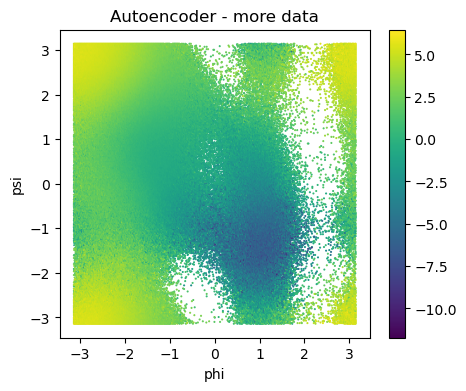

In [41]:
n_components = 1

fig,axs = plt.subplots(1, n_components, figsize = ( 5 * n_components, 4) )
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    new_df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='viridis',ax=ax, gridsize=400)
    ax.set_title(f'Autoencoder - more data')

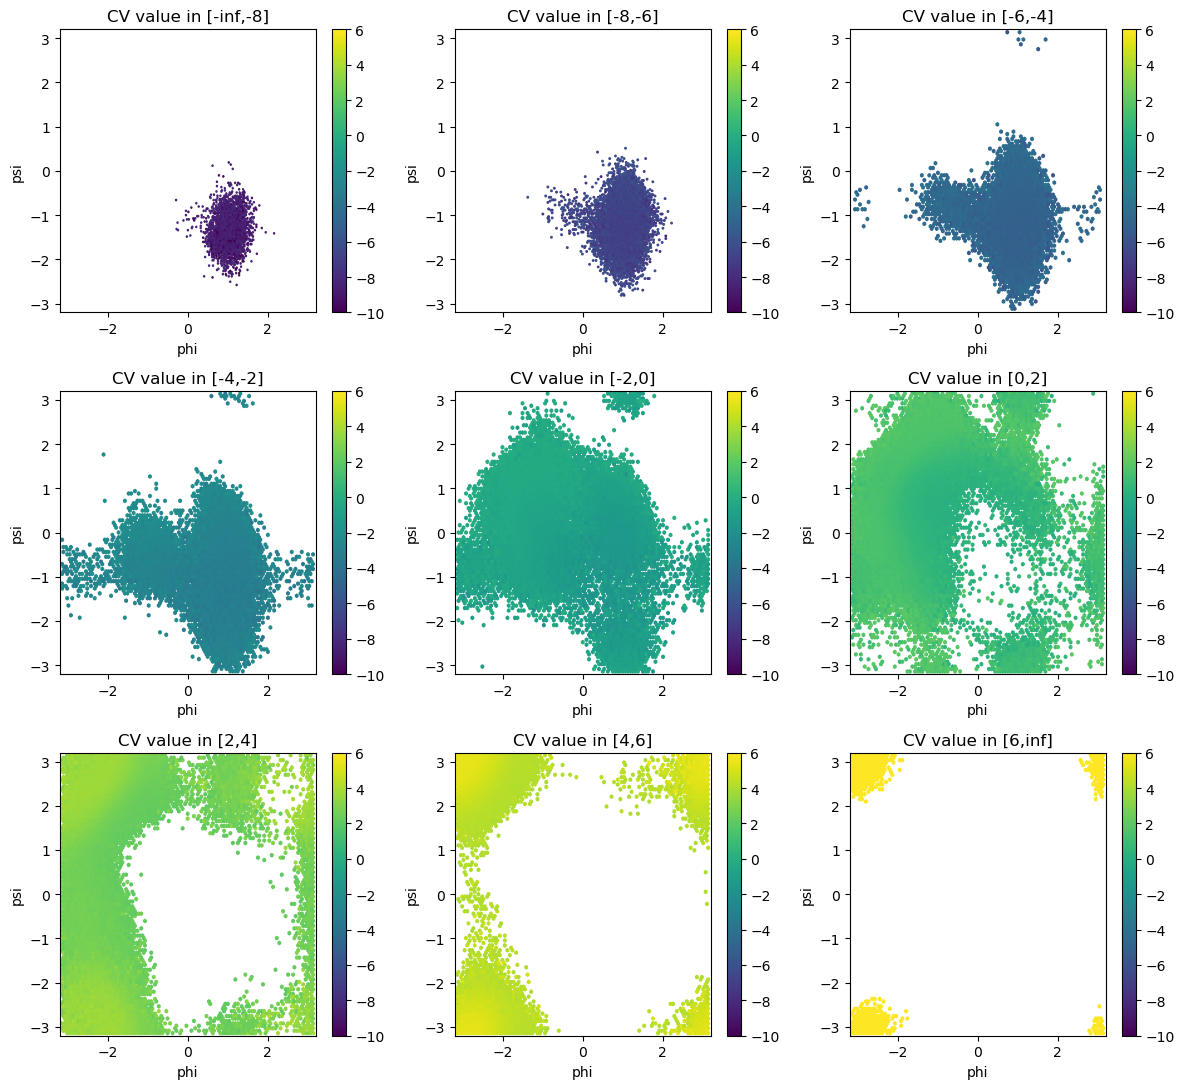

In [88]:
n_components = 1

fig,axs = plt.subplots(3, 3, figsize = ( 12, 11 ) )
axs = axs.ravel()

boundary = [-np.inf, -8, -6, -4, -2, 0, 2, 4, 6, np.inf]
for i in range(0, 9):
	ax = axs[i]
	new_df[(new_df[f'CV0'] < boundary[i+1]) & (new_df[f'CV0'] > boundary[i])].plot.hexbin('phi', 'psi', C=f'CV0', cmap='viridis', ax=ax, vmin=-10, vmax=6)
	ax.set_title(f'CV value in [{boundary[i]},{boundary[i+1]}]')
	ax.set_xlim(-3.2, 3.2)
	ax.set_ylim(-3.2, 3.2)
plt.tight_layout()